In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, KFold


In [2]:

def generate_data(n, gamma):  # Pour la reproductibilité

   
    mean1 = [0, 0]
    mean2a = [0, 1]
    gamma_rad = np.deg2rad(gamma)
    mean2b = [np.cos(gamma_rad), np.sin(gamma_rad)]
    cov = np.diag([0.2, 0.2])  # Covariance matrix
    
    n_class = n // 2

    class1 = np.random.multivariate_normal(mean1, cov, n_class)
    
    class2a = np.random.multivariate_normal(mean2a, cov, n_class // 2)
    class2b = np.random.multivariate_normal(mean2b, cov, n_class // 2)
    class2 = np.vstack((class2a, class2b))
    
    labels_class1 = np.zeros(n_class)
    labels_class2 = np.ones(n_class)
    
    X = np.vstack((class1, class2))
    y = np.hstack((labels_class1, labels_class2))
    
    return X, y


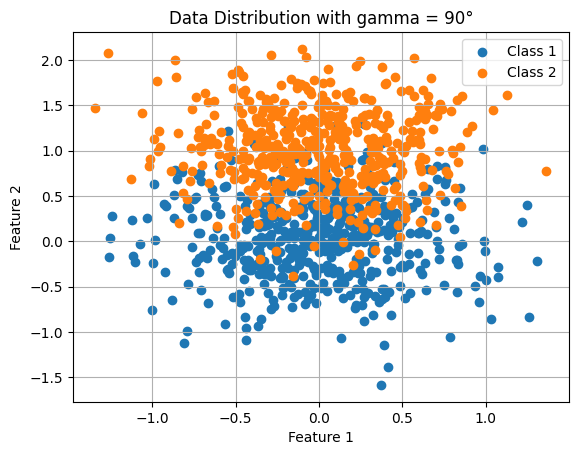

In [3]:

n = 1000
gamma = 90 
m=150 
X, y = generate_data(n, gamma)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=m, random_state=42)

# Visualisation
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label='Class 1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Class 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title(f'Data Distribution with gamma = {gamma}°')
plt.grid(True)
plt.show()


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=m, random_state=42)

# XGBoost 
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# Analyse Discriminante Linéaire (LDA)
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, y_train)
y_pred_lda = lda_classifier.predict(X_test)
accuracy_lda = accuracy_score(y_test, y_pred_lda)

In [5]:
print(f"Accuracy of XGBoost: {accuracy_xgb:.2f}")
print(f"Accuracy of Linear Discriminant Analysis: {accuracy_lda:.2f}")

Accuracy of XGBoost: 0.84
Accuracy of Linear Discriminant Analysis: 0.88


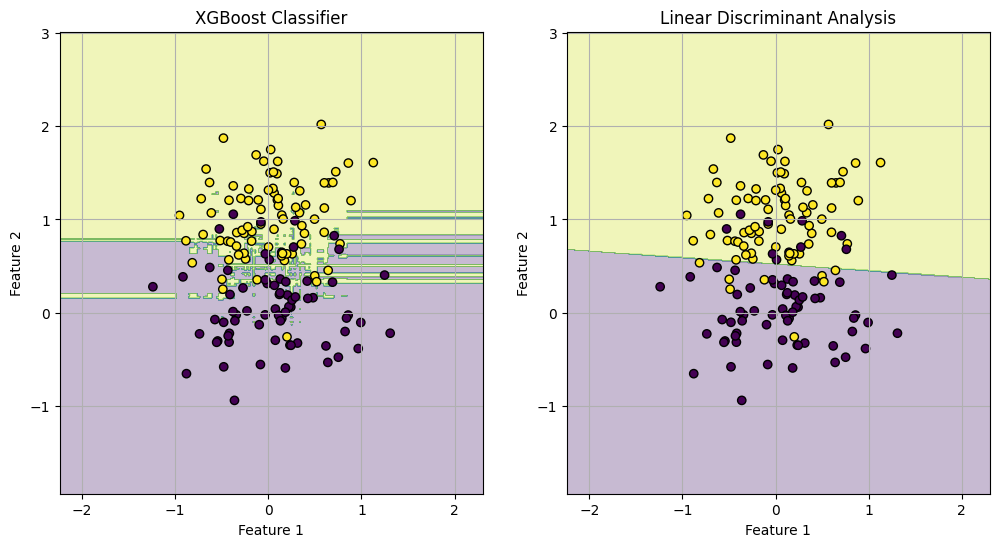

In [6]:

# Visualisation des frontières de décision
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)

# Tracer les frontières de décision
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_decision_boundary(xgb_classifier, X_test, y_test, 'XGBoost Classifier')
plt.subplot(1, 2, 2)
plot_decision_boundary(lda_classifier, X_test, y_test, 'Linear Discriminant Analysis')
plt.show()

In [7]:
gamma_values = [0, 5, 10, 15, 20, 30, 50, 70, 90]

In [8]:
def power_simulation(n, m, num_simulations):

    np.random.seed(42)

    power = []
    esperances = []
    variances = []
    test_statistics = []
    test_alternative = []
    delta_list = []

    for gamma in gamma_values:

        differences = []

        for _ in range(num_simulations):

            X, y = generate_data(n+m, gamma)

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=m, random_state=42)

            # XGBoost
            xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
            xgb_classifier.fit(X_train, y_train)
            y_pred_xgb = xgb_classifier.predict(X_test)
            accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

            # Linear Discriminant
            lda_classifier = LinearDiscriminantAnalysis()
            lda_classifier.fit(X_train, y_train)
            y_pred_lda = lda_classifier.predict(X_test)
            accuracy_lda = accuracy_score(y_test, y_pred_lda)

            differences.append(accuracy_lda - accuracy_xgb)

        d_barre = sum(differences)/num_simulations 
        var = np.var(differences, ddof=1)
        test_stat = (num_simulations**0.5)*d_barre/np.sqrt(var) # Statistique pour l'hypothèse nulle

        delta = d_barre
        student = stats.t.ppf(0.95, df=num_simulations-1)
        mu = (num_simulations ** 0.5)*delta/np.sqrt(var)
        test_alt = student - mu
        puissance = 1 - stats.norm.cdf(student - mu, 0, 1)
       
        delta_list.append(delta)
        esperances.append(d_barre)
        variances.append(var)
        test_statistics.append(test_stat)
        test_alternative.append(test_alt)
        power.append(puissance)

    return esperances, variances, test_statistics, test_alternative, power


In [9]:
esperances, variances, test_statistics, test_alternative, power = power_simulation(150, 150, 1000)

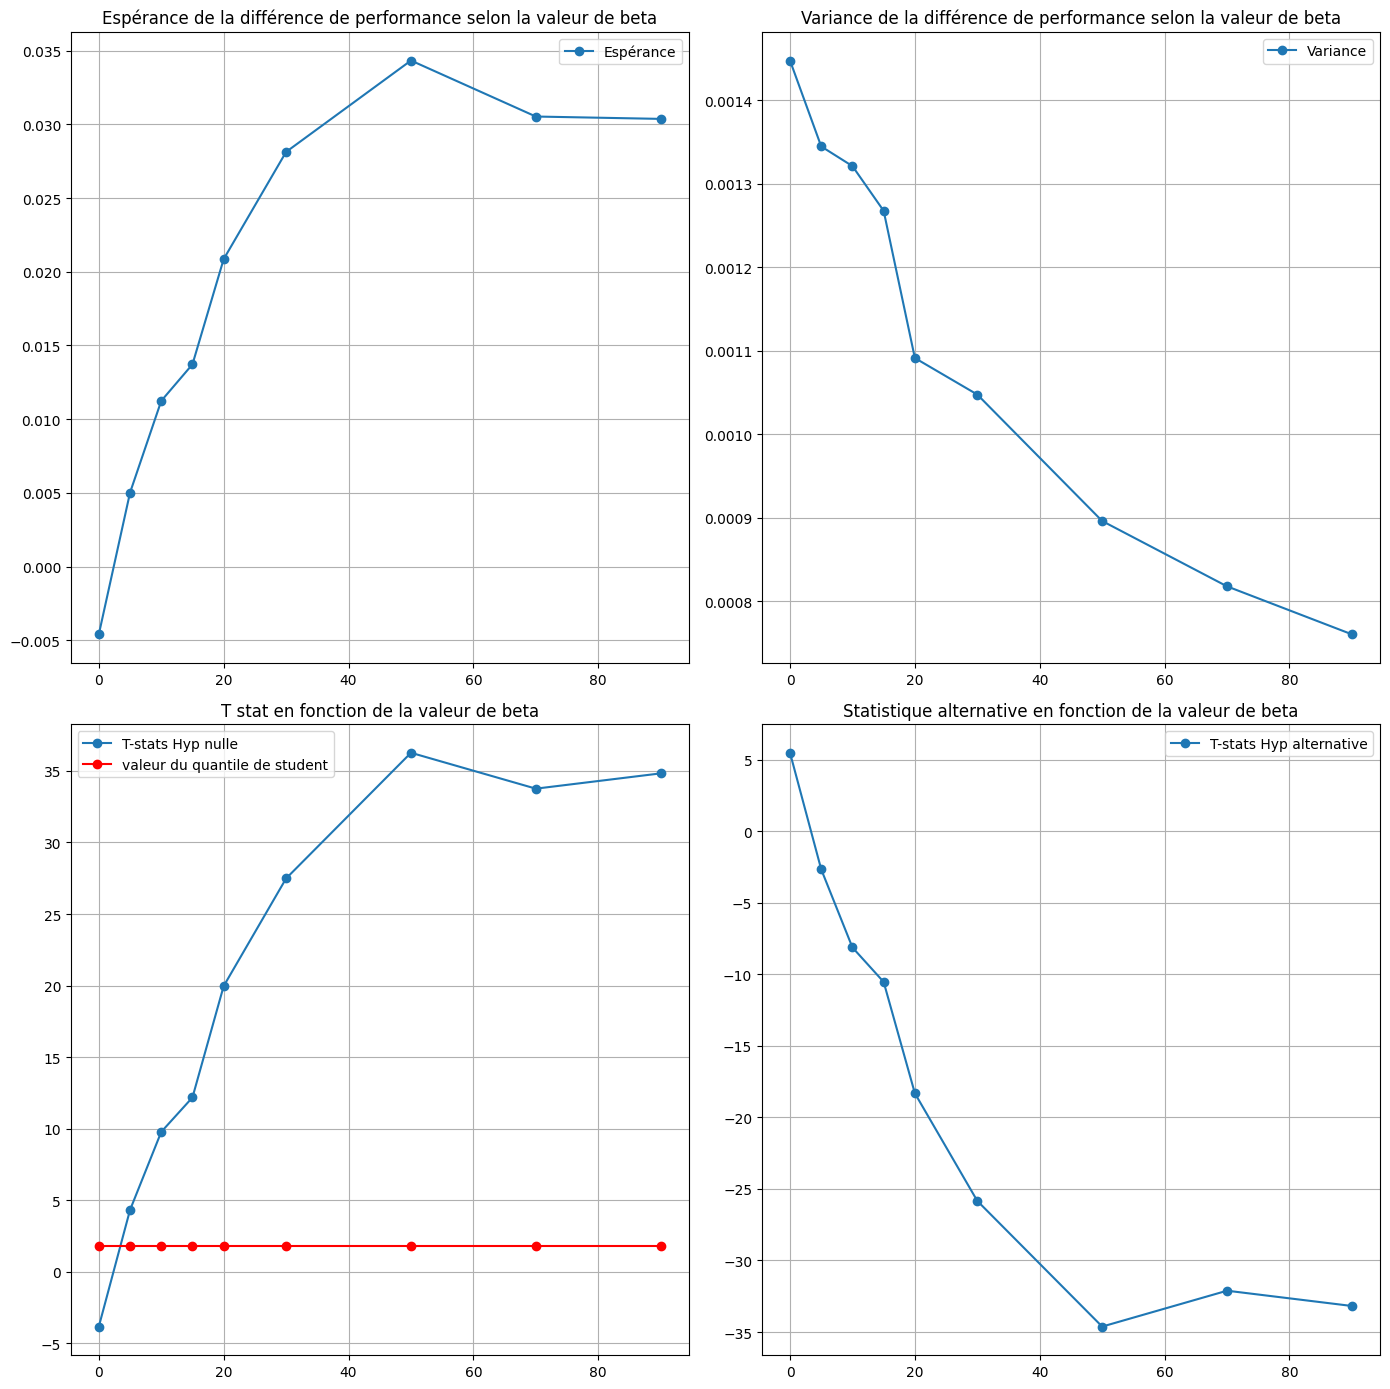

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

# Premier sous-graphe : Espérance
axes[0, 0].plot(gamma_values, esperances, label='Espérance', marker='o')
axes[0, 0].set_title('Espérance de la différence de performance selon la valeur de beta')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Deuxième sous-graphe : Variance
axes[0, 1].plot(gamma_values, variances, label='Variance', marker='o')
axes[0, 1].set_title('Variance de la différence de performance selon la valeur de beta')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Troisième sous-graphe : T-stat Hyp nulle
axes[1, 0].plot(gamma_values, test_statistics, label='T-stats Hyp nulle', marker='o')
axes[1, 0].plot(gamma_values, [stats.t.ppf(0.95, df=9)]*len(gamma_values), label='valeur du quantile de student', color='r', marker='o')
axes[1, 0].set_title('T stat en fonction de la valeur de beta')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Quatrième sous-graphe : T-stat Hyp alternative
axes[1, 1].plot(gamma_values, test_alternative, label='T-stats Hyp alternative', marker='o')
axes[1, 1].set_title('Statistique alternative en fonction de la valeur de beta')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

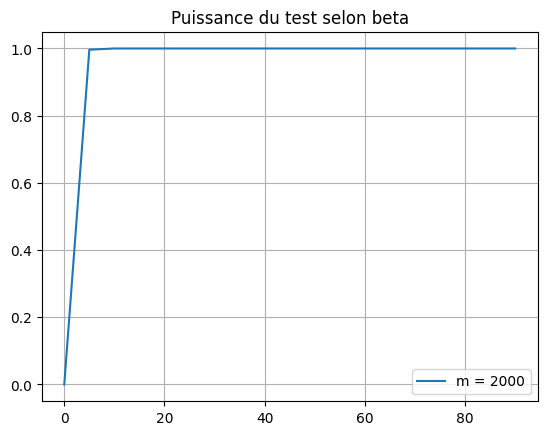

In [11]:
plt.figure()
plt.title("Puissance du test selon beta")
plt.plot(gamma_values, power, label = "m = 2000")
plt.grid()
plt.legend()
plt.show()

In [12]:
exp_df = pd.DataFrame(power)
exp_df

,0
0,2.249906e-08
1,9.962887e-01
2,1.000000e+00
3,1.000000e+00
4,1.000000e+00
5,1.000000e+00
6,1.000000e+00
7,1.000000e+00
8,1.000000e+00


In [13]:
real_data = {
    'γ': [0, 5, 10, 15, 20, 30, 50, 70, 90],
    'Simulation (m=2000)': [0.000, 0.000, 0.000, 0.000, 0.045, 0.884, 1.000, 1.000, 0.999],
    'Simulation (m=200)': [0.006, 0.022, 0.064, 0.152, 0.285, 0.632, 0.965, 0.837, 0.823],
    'Competition': [0.011, 0.039, 0.113, 0.236, 0.409, 0.730, 0.958, 0.827, 0.712],
    'Real World (OOB)': [0.016, 0.050, 0.123, 0.242, 0.385, 0.695, 0.938, 0.781, 0.721],
    'Real World (OOB-2n)': [0.001, 0.006, 0.024, 0.088, 0.202, 0.514, 0.942, 0.867, 0.803],
    'Real World (CV)': [0.016, 0.049, 0.120, 0.262, 0.451, 0.770, 0.949, 0.799, 0.733]
}

real_df = pd.DataFrame(real_data)

print(real_df)


    γ  Simulation (m=2000)  Simulation (m=200)  Competition  Real World (OOB)  \
0   0                0.000               0.006        0.011             0.016   
1   5                0.000               0.022        0.039             0.050   
2  10                0.000               0.064        0.113             0.123   
3  15                0.000               0.152        0.236             0.242   
4  20                0.045               0.285        0.409             0.385   
5  30                0.884               0.632        0.730             0.695   
6  50                1.000               0.965        0.958             0.938   
7  70                1.000               0.837        0.827             0.781   
8  90                0.999               0.823        0.712             0.721   

   Real World (OOB-2n)  Real World (CV)  
0                0.001            0.016  
1                0.006            0.049  
2                0.024            0.120  
3                0.08

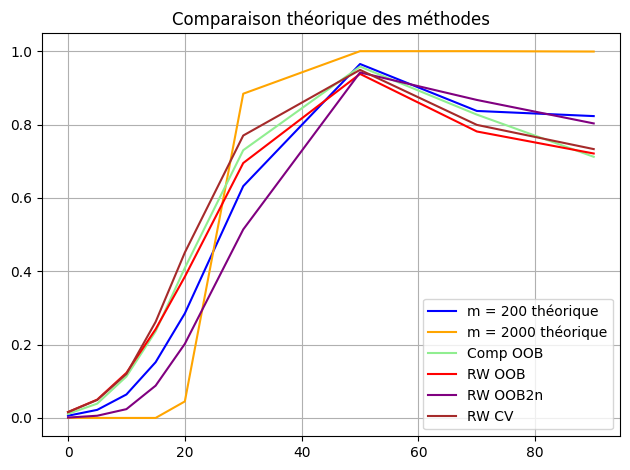

In [14]:
plt.title("Comparaison théorique des méthodes")
plt.plot(gamma_values, real_df["Simulation (m=200)"], label="m = 200 théorique", color="blue")
plt.plot(gamma_values, real_df["Simulation (m=2000)"], label="m = 2000 théorique", color="orange")
plt.plot(gamma_values, real_df["Competition"], label="Comp OOB", color="lightgreen")
plt.plot(gamma_values, real_df["Real World (OOB)"], label="RW OOB", color="red")
plt.plot(gamma_values, real_df["Real World (OOB-2n)"], label="RW OOB2n", color="purple")
plt.plot(gamma_values, real_df["Real World (CV)"], label="RW CV", color="brown")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()